# Circle Packing

## Introduction

We aim to pack some circles

In [1]:
#HOME = "/home/coopar7/Documents/code/"
HOME = "/home/jon/Documents/UBCMRI/"
cd(HOME * "BlochTorreyExperiments-master/")

In [2]:
using Traceur
using BenchmarkTools
using StaticArrays
using JuAFEM
using JuAFEM: vertices, faces, edges
using MATLAB
using LinearMaps
#using DifferentialEquations
using Optim
using Cuba
using Distributions
#using ApproxFun
#using Plots

include("Experiments/MyelinWaterOrientation/Geometry/geometry_utils.jl")
include("Experiments/MyelinWaterOrientation/Geometry/circle_packing.jl")
include("Experiments/MyelinWaterOrientation/Utils/mesh_utils.jl")
include("Experiments/MyelinWaterOrientation/Utils/blochtorrey_utils.jl")
Revise.track("Experiments/MyelinWaterOrientation/Geometry/geometry_utils.jl")
Revise.track("Experiments/MyelinWaterOrientation/Geometry/circle_packing.jl")
Revise.track("Experiments/MyelinWaterOrientation/Utils/mesh_utils.jl")
Revise.track("Experiments/MyelinWaterOrientation/Utils/blochtorrey_utils.jl")

In [3]:
# α or k == R_shape, θ == R_scale
R_mu = 0.46 # Axon mean radius [um] ; this is taken to be outer radius
R_shape = 5.7 # Axon radius shape parameter for Gamma distribution (Xu)
R_scale = R_mu / R_shape # Axon radius scale parameter [um]
R_σ = sqrt(R_shape)*R_scale; # Axon radius variance

In [27]:
revise()

In [17]:
const Dim = 2
Ncircles = 150
rs = rand(Gamma(R_shape, R_scale), Ncircles);
os = initialize_origins(rs);

In [18]:
ϵ = 0.1*R_mu
α = 5e-6

@time circles_opt, opt_result = pack_circles(rs; initial_origins=os, distancescale = R_mu, alpha=α, epsilon=ϵ);

 19.782728 seconds (403.62 k allocations: 62.963 MiB, 0.08% gc time)


In [ ]:
opt_result

In [ ]:
ConstrainedOpts = Optim.Options(iterations = 100_000,
                                g_tol = 1e-12,
                                allow_f_increases = false)

@time circles_opt_con, opt_result_con = pack_circles(rs;
                                                     initial_origins = origin.(circles_opt),
                                                     constrained = true,
                                                     epsilon = ϵ,
                                                     Opts = ConstrainedOpts);

In [ ]:
opt_result_con

In [ ]:
cs_plot = circles_opt_con;

In [22]:
cs_plot = circles_opt;

In [23]:
revise()

In [24]:
Nmin = 50; # points for smallest circle
h0 = 2pi*mean(c->radius(c), cs_plot)/Nmin; # approximate scale
#h0 = ϵ
eta = 4.0; # approx ratio between largest/smallest edges
b_box = bounding_box(cs_plot)

Rectangle{2,Float64}([-0.848169, -5.98505], [13.1315, 7.59411])

In [10]:
FinElPath = HOME * "MatlabTools/FiniteElements/"
mxcall(:addpath,0,mxcall(:genpath,1,FinElPath))

In [11]:
fullgrid, subgrids = square_mesh_with_circles(b_box, cs_plot, h0, eta, isunion=true);

In [ ]:
revise()

In [ ]:
#@benchmark estimate_density(cs_plot)

In [25]:
ρ = Fun(α->estimate_density(cs_plot,α), 0.05..1.0)

Fun(Chebyshev(【0.05,1.0】),[0.796823, -0.058385, -0.0139267, -0.0219859, -0.00265391, 0.0046485, -0.0034223, 0.00633126, -0.00520447, 0.00241029  …  -5.74941e-11, 8.77337e-12, 5.51139e-12, 8.01059e-12, -6.95997e-12, 1.00628e-11, -2.39306e-11, -1.00581e-11, 8.38082e-11, -1.02572e-10])

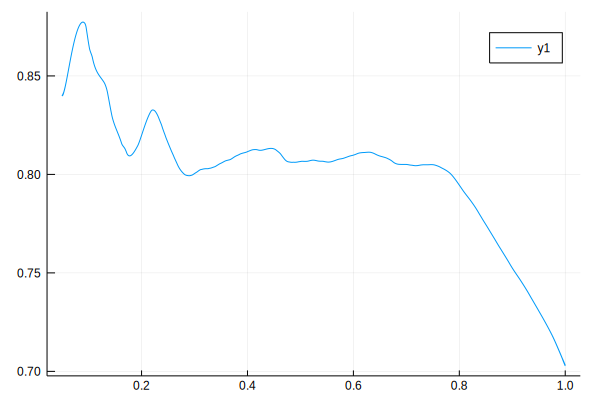

In [26]:
plot(ρ)

In [19]:
#@time estimate_density(cs_plot)
alphas = 0.05:0.05:1.0;
[alphas estimate_density.([cs_plot], alphas)];

In [ ]:
@time estimate_density_monte_carlo(cs_plot; integrator = Cuba_integrator(:cuhre))

In [ ]:
for method in [:suave, :vegas, :divonne, :cuhre]
    res = estimate_density_monte_carlo(cs_plot; integrator = Cuba_integrator(method))
    @show (method, res...)
end

In [ ]:
#@benchmark estimate_density_monte_carlo(cs_plot; integrator = Cuba_integrator(:suave))

In [ ]:
#@benchmark estimate_density_monte_carlo(cs_plot; integrator = Cuba_integrator(:vegas))

In [ ]:
#@benchmark estimate_density_monte_carlo(cs_plot; integrator = Cuba_integrator(:divonne))

In [ ]:
#@benchmark estimate_density_monte_carlo(cs_plot; integrator = Cuba_integrator(:cuhre))

In [ ]:
overlap_mat = zeros(Bool, Ncircles, Ncircles);
[overlap_mat[i,j] = is_overlapping(cs_plot[i], cs_plot[j]) for i in 1:Ncircles for j in 1:Ncircles]
overlap_mat;

In [ ]:
dist_mat = zeros(Ncircles, Ncircles);
for i in 1:Ncircles-1, j in 1:i-1
    dist_mat[i,j] = signed_edge_distance(cs_plot[i], cs_plot[j])
end
min_dist = minimum(x->x==zero(x) ? Inf : x, dist_mat)
eps_dist = ϵ
@show min_dist
@show eps_dist
@show 100*(eps_dist - min_dist)/eps_dist;

In [ ]:
dist_mat;

In [ ]:
revise()

In [ ]:
bcircle = crude_bounding_circle(cs_plot)

In [ ]:
fullgrid, subgrids = square_mesh_with_circles(bbox, [circles_opt..., bcircle], h0, eta, isunion=true);

In [ ]:
#x0 = copy(reinterpret(Float64, os))
#origins_chunk = Float64[]
#rs_chunk = Float64[]
#
#@time begin
#    Alg = LBFGS()
#    opts = Optim.Options(iterations=10)
#    fs = (origins, radii) -> energy_sum_overlap_squared_distances(c_0,origins,radii,Val{Dim}) + λ*energy_sum_squared_distances(c_0,origins,radii,Val{Dim})
#    for i = 1:Ncircles-1
#        push!(origins_chunk, x0[2i-1:2i]...)
#        push!(rs_chunk, rs[i])
#
#        result = optimize(origins -> fs(origins, rs_chunk), origins_chunk, Alg, opts) # partial minimization
#        origins_chunk = copy(Optim.minimizer(result))
#
#        @show (i, Optim.minimum(result))
#    end
#    x = copy(origins_chunk)
#    result = optimize(origins -> fs(origins, rs), x, Alg, Optim.Options(iterations=100_000)) # full minimization
#end

In [ ]:
for i in 1:Ncircles-1
    c_i = circles_opt[i]
    for j in i+1:Ncircles
        c_j = circles_opt[j]
        
        #if circle_edge_distance(c_i, c_j) < 0
        #    @show (i, j, c_i, c_j)
        #end
        #@show circle_edge_distance(c_i, c_j)^2
        dx = (origin(c_i)-origin(c_j))
        @show norm(dx)
    end
end

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*